In [1]:
#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)

In [2]:
number_of_top_items = '3000'
plot_name = number_of_top_items[0] + 'k'

#print(plot_name)

df = pd.read_pickle('/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top'+number_of_top_items+'_seller_YTD_group_by_item_visit.pickle')


In [3]:
print(df.item_code.nunique())



2713


In [4]:
#print(df.dtypes)

In [5]:
def filter_df(DF = df,bins=6, avg_PDP = 19.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt  = df_filt.merge(df_items,on='item_code',how='inner')
    df_filt  = df_filt[df_filt['item_price_y']== True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [6]:
df_filt = filter_df(df)


print(df_filt.item_code.nunique())

2378


In [7]:
#introducing the similarity score 
sim_score = pd.read_parquet('/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-5f77392a-0bfa-4f0b-a4ae-d816ce2d71de-c000.snappy.parquet')

In [8]:
sim_score

,sku,recommended_sku,score
0,000000001000200072,000000001000200087,0.260000
1,000000001000200072,000000001000183538,0.216580
2,000000001000200072,000000001000142209,0.200000
3,000000001000200072,000000001000204906,0.190794
4,000000001000200072,000000001000183468,0.183980
...,...,...,...
3827600,000000001000064787,000000001000115010,0.203238
3827601,000000001000064787,000000001000112641,0.201339
3827602,000000001000064787,000000001000046204,0.200052
3827603,000000001000064787,000000001000114086,0.199867


In [9]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())


sim_score_filt = sim_score[sim_score['sku'].isin(unique_item_codes)]

sim_score_filt

,sku,recommended_sku,score
820,000000001000180146,000000001000180137,0.904849
821,000000001000180146,000000001000180888,0.448651
822,000000001000180146,000000001000192222,0.381316
823,000000001000180146,000000001000031296,0.321612
824,000000001000180146,000000001000176646,0.278406
...,...,...,...
3827360,000000001000176744,000000001000171107,0.339302
3827361,000000001000176744,000000001000163202,0.335340
3827362,000000001000176744,000000001000163190,0.327887
3827363,000000001000176744,000000001000176438,0.324293


In [10]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items = unique_item_codes , df=sim_score_filt, score_cut = 0.):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['sku'] == item_code]
        df_score_filt = df_mod[df_mod['score'] > score_cut]
        final_set_sku = list(df_score_filt.recommended_sku)
        final_set_sku.insert(0,item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)
    return map_of_items


In [11]:
sim_score_bin = [0.16]#0.3,0.4,0.5,0.6,0.7,0.8,0.9]




In [12]:
map_of_map_of_items = {}
for sim_score_i in sim_score_bin:
    Map_of_Items = create_map(score_cut = sim_score_i)
    map_of_map_of_items[str(sim_score_i)] = Map_of_Items
#print(map_of_map_of_items)

In [13]:
#load greater dataset 
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit.pickle'
dataset10k = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top10000_seller_YTD_group_by_item_visit.pickle'

#df_k = pd.read_pickle(dataset10k)
df_k = pd.read_pickle(largest_dataset)

In [14]:
PDP_bin = [19]#,30,40,50]

In [15]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP= PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [16]:
def create_map_of_dataframes(items_map = Map_of_Items,df=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items  = items_map[key]
        #print(f'Item_code = {key}')
        
        df_mod = df[df['item_code'].isin(items)]
        #
        #print(f'Number of items per cluster {df_mod.item_code.nunique()}')
        map_of_df[key]= df_mod
    return map_of_df



In [17]:
def run_model(item_code, df, map_results):
    #print('\n')
    #print(f'Running model for the item = {item_code}')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
    #print(wls_cr_with_fe.summary())
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)
    flag_stat_ok = abs((3*beta_std_err_log_price)/beta_log_price) < 1.

    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), True]
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), False]
        #print(map_results[item_code])
        return False


In [18]:
df_result = pd.DataFrame()

map_of_maps_of_df = {}
#print('Cut on PDP, sim_score, result = ')
for PDP_cut in df_PDP_bin_filt.keys():
    for score_cut in  map_of_map_of_items.keys():
        map_of_dfs = create_map_of_dataframes(map_of_map_of_items[score_cut],df=df_PDP_bin_filt[PDP_cut])
        map_of_maps_of_df[PDP_cut] = map_of_dfs
        print(f'Number of items passing the PE cut {len(map_of_dfs)}')

        map_result = {}

        #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
        map_items_stat = {}
        for key in map_of_dfs.keys():
            map_items_stat[key] = run_model(key, map_of_dfs[key], map_result)

            #print(map_result)

        items_stat_series = pd.Series(map_items_stat)
        #print(map_items_stat)
        #print(items_stat_series)


        
        x,y, y_err, rel_err = {'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]}
        for i_code,flag in items_stat_series.items():
        #flag=T
            if flag == True:

                y['True'].append(map_result[i_code][0])
                y_err['True'].append(map_result[i_code][1])
                x['True'].append(map_result[i_code][-2])
                rel_err['True'].append(abs(map_result[i_code][1]/map_result[i_code][0]))
            else:
                y['False'].append(map_result[i_code][0])
                y_err['False'].append(map_result[i_code][1])
                x['False'].append(map_result[i_code][-2])
                rel_err['False'].append(abs(map_result[i_code][1]/map_result[i_code][0]))
                continue
        #print(f'{PDP_cut},{score_cut} , {len(x)}')
        df_result = pd.DataFrame.from_dict(map_result, orient='index', columns = ['PE', 'PE_err', 'log_del_week', 'log_del_week_err', 'Cluster_size', 'has_enough_stat'])
        #print (df_result.head(100))


Number of items passing the PE cut 2378


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.

In [19]:
df_result_true = df_result[df_result['has_enough_stat']==True]
print(len(df_result_true.index))
#print(df_result.head(100))

df_filt_result_high = df_result_true[df_result_true['PE'] < -0.05]

#print(df_filt_result_high.head(100))

items_to_test = list(df_filt_result_high.index.values)
#print(items_to_test)
print(len(items_to_test))
#for item in items_to_test:
    #print(map_of_dfs[str(item)])
    #df_of_df = pd.DataFrame().from_dict(map_of_dfs[str(item)], orient = 'columns')
    #print(df_of_df)#
#    break

1124
181


In [20]:
df_filt_result_low = df_result_true[df_result_true['PE'] > -0.02]
#print(df_filt_result_low.head(100))
items_to_test_low = list(df_filt_result_low.index.values)
#print(items_to_test_low)
print(len(items_to_test_low))

346


In [21]:
df_result_false = df_result[df_result['has_enough_stat']==False]
#print(df_result_false.head(100))
items_false = list(df_result_false.index.values)
#print(items_false)
print(len(items_false))

1254


In [22]:
import matplotlib.lines as mlines

def create_legend(flag={'blue' : 'Items with sign stat', 'red': 'Items with not sign stat'}):
    good_stat_leg = []
    for key in flag.keys():
        good_stat_leg.append( mlines.Line2D([], [], color=key, marker = 'o',
                          markersize=6, label=flag[key]))
        
    plt.legend(handles=good_stat_leg)

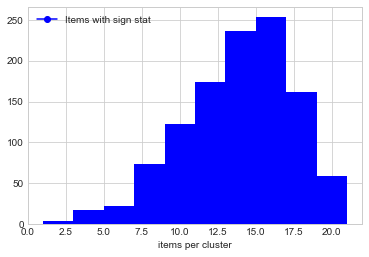

In [23]:
plt.hist(x['True'], color= 'blue')
plt.xlabel('items per cluster')
create_legend({'blue':'Items with sign stat'})
plt.savefig('./plots/items_per_cluster_good_top'+plot_name+'.png')
plt.show()

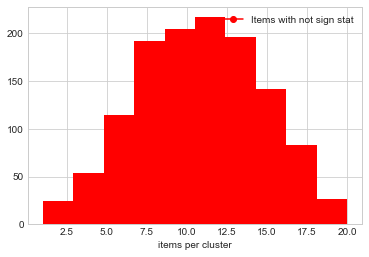

In [24]:
plt.hist(x['False'],color ='red')
plt.xlabel('items per cluster')
create_legend({'red':'Items with not sign stat'})
plt.savefig('./plots/items_per_cluster_bad_top'+plot_name+'.png')
plt.show()

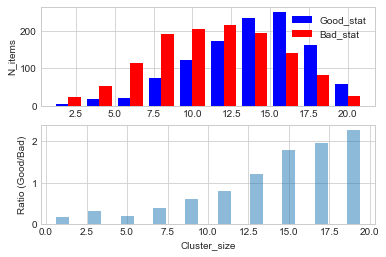

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ns, bins, patches = ax1.hist([x['True'],x['False']],
                      label=['Good_stat','Bad_stat'],
                      color = ['blue','red']
                      )

ax1.legend()

ax2.bar(bins[:-1],     # this is what makes it comparable
            ns[0] / ns[1], # maybe check for div-by-zero!
        alpha=0.5)

ax1.set_ylabel('N_items')
ax2.set_ylabel('Ratio (Good/Bad)')
ax2.set_xlabel('Cluster_size')


plt.savefig('./plots/ratio_cluster_size_bad_top'+plot_name+'.png')



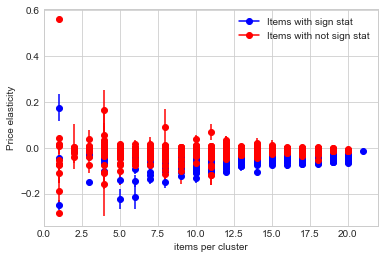

In [26]:
plt.errorbar(x['True'], y['True'], yerr=y_err['True'],fmt='o', c='blue')
plt.errorbar(x['False'], y['False'], yerr=y_err['False'],fmt='o',c='red')
plt.xlabel('items per cluster')
plt.ylabel('Price elasticity')


create_legend()
plt.savefig('./plots/PE_vs_items_per_cluster_top'+plot_name+'.png')
plt.show()



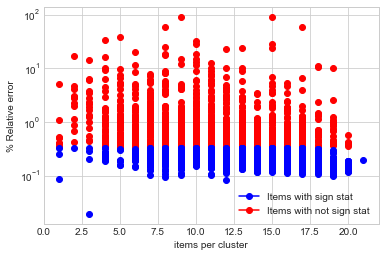

In [27]:
plt.scatter(x['False'],rel_err['False'],c='red')
plt.scatter(x['True'],rel_err['True'],c='blue')
plt.xlabel('items per cluster')
plt.ylabel('% Relative error')
plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_items_per_cluster_top'+plot_name+'.png')
plt.show()

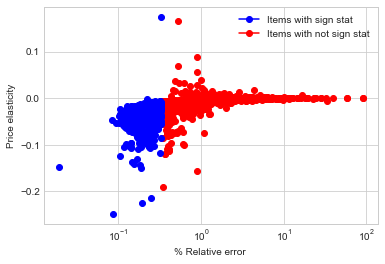

In [28]:
plt.scatter(rel_err['False'],y['False'],c='red')
plt.scatter(rel_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('% Relative error ')
plt.xscale('log')
#plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_PE_top'+plot_name+'.png')
plt.show()



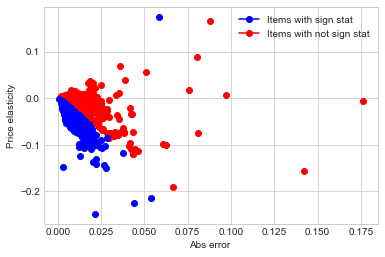

In [29]:
plt.scatter(y_err['False'],y['False'],c='red')
plt.scatter(y_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('Abs error ')
#plt.xscale('log')
create_legend()
plt.savefig('./plots/Abs_error_vs_PE_top'+plot_name+'.png')
plt.show()



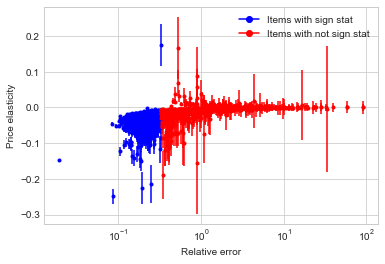

In [30]:
plt.errorbar(rel_err['True'], y['True'], yerr=y_err['True'],fmt='.', c='blue')
plt.errorbar(rel_err['False'], y['False'], yerr=y_err['False'],fmt='.',c='red')
plt.xlabel('Relative error')
plt.ylabel('Price elasticity')
plt.xscale('log')

create_legend()
plt.savefig('./plots/Rel_err_vs_PE_plus_abs_err_top'+plot_name+'.png')
plt.show()

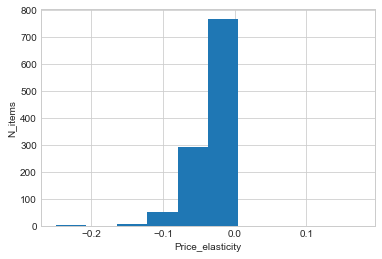

In [31]:
plt.hist(y['True'])
plt.xlabel('Price_elasticity')
plt.ylabel('N_items')
plt.savefig('./plots/PE_histo_top'+plot_name+'.png')
plt.show()


In [32]:
import statistics
print(statistics.median(y['True']))


-0.0268


In [33]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

y['True'].sort()
three_list = list(split(y['True'],3))


print(three_list[0][-1],three_list[1][-1] )

-0.036 -0.0206


In [34]:
df_result_true_high = df_result_true[df_result_true['PE'] <= three_list[0][-1] ]
print(len(df_result_true_high.index))
df_result_true_medium = df_result_true[ (df_result_true['PE'] > three_list[0][-1] ) & ( df_result_true['PE'] <= three_list[1][-1])]
print(len(df_result_true_medium.index))
df_result_true_low = df_result_true[df_result_true['PE'] > three_list[1][-1] ]
print(len(df_result_true_low.index))

375
375
374


In [35]:
list_high   = list(df_result_true_high.index)
list_medium = list(df_result_true_medium.index)
list_low    = list(df_result_true_low.index)
#print(df_result_true_high.index)

In [36]:
df_result_true_high.to_csv('./pickle_files/Top'+plot_name+'_high_el.csv')
df_result_true_medium.to_csv('./pickle_files/Top'+plot_name+'_medium_el.csv')
df_result_true_low.to_csv('./pickle_files/Top'+plot_name+'_low_el.csv')

In [37]:
import pickle
def save_obj(obj, name ):
    with open('pickle_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [65]:
#Read_item_code

df_reach = pd.read_csv('../raw_data/stock_av/item_code_stock_reach.csv',dtype = {'item_code':str})

#df_reach= df_reach.astype({'item_code': 'string'})
print(df_reach.dtypes)
avl_item = list(df_reach.item_code.values)
print(avl_item[0])

item_code                object
available_stock           int64
avg_sales_forecasted    float64
reach                   float64
dtype: object
000000001000208731


In [44]:
df_result_true = df_result_true[['PE','PE_err']]
#print(df_result_true.head())
#print(df_result_true.columns)

                        PE  PE_err
000000001000021922 -0.0188  0.0034
000000001000126849 -0.0089  0.0029
000000001000005727 -0.0460  0.0073
000000001000007822 -0.0246  0.0073
000000001000116614 -0.0141  0.0030
Index(['PE', 'PE_err'], dtype='object')


In [55]:
#df_result_true = df_result_true.rename(column_index={'':'item_code'})
print(df_result_true.head(1000))
print(df_result_true.dtypes)

                        PE  PE_err
000000001000021922 -0.0188  0.0034
000000001000126849 -0.0089  0.0029
000000001000005727 -0.0460  0.0073
000000001000007822 -0.0246  0.0073
000000001000116614 -0.0141  0.0030
...                    ...     ...
000000001000117172 -0.0360  0.0072
000000001000082095 -0.0170  0.0042
000000001000186228 -0.0158  0.0032
000000001000016023 -0.0488  0.0072
000000001000096490 -0.0352  0.0111

[1000 rows x 2 columns]
PE        float64
PE_err    float64
dtype: object


In [56]:
print(avl_item)

[1000208731, 1000174885, 1000174813, 1000224524, 1000075000, 1000174978, 1000092143, 1000075003, 1000208732, 1000090822, 1000208734, 1000119632, 1000215112, 1000164750, 1000208730, 1000174884, 1000208735, 1000101404, 1000187774, 1000075002, 1000074998, 1000224526, 1000092141, 1000090865, 1000174806, 1000072366, 1000174822, 1000174887, 1000174975, 1000174818, 1000215101, 1000208243, 1000092145, 1000208721, 1000215100, 1000092144, 1000174833, 1000151818, 1000187768, 1000135006, 1000021947, 1000191290, 1000125854, 1000231374, 1000104693, 1000190248, 1000192625, 1000211697, 1000096566, 1000191305, 1000207596, 1000104689, 1000122308, 1000200950, 1000124560, 1000087410, 1000021933, 1000096764, 1000175277, 1000158791, 1000223392, 1000135759, 1000227887, 1000207642, 1000190240, 1000135013, 1000135008, 1000201861, 1000231377, 1000223357, 1000125858, 1000047706, 1000231376, 1000124558, 1000135004, 1000125860, 1000223394, 1000158727, 1000190249, 1000160236, 1000021921, 1000147145, 1000158732, 100

In [121]:
df_stock_filt=df_result_true[df_result_true.index.isin(avl_item)]
print(df_stock_filt.head())

print(len(df_stock_filt.index))

                        PE  PE_err
000000001000005727 -0.0460  0.0073
000000001000007822 -0.0246  0.0073
000000001000008470 -0.0643  0.0105
000000001000022615 -0.0888  0.0186
000000001000008474 -0.0433  0.0123
395


In [87]:
#PREPARE THE CONVERSION RATE FILE
final_items = list(df_stock_filt.index.values)
print(len(final_items))



395


In [88]:
print(df_filt.head(10))

     min_date    max_date           item_code  item_price_x  delivery_weeks  \
0  2020-01-01  2020-03-13  000000001000021922        129.99               2   
1  2020-04-15  2020-04-21  000000001000021922        119.99               4   
2  2020-04-23  2020-06-07  000000001000021922        129.99               2   
3  2020-06-11  2020-07-25  000000001000021922        129.99               2   
4  2020-07-31  2020-08-10  000000001000021922        119.99               2   
5  2020-08-11  2020-08-18  000000001000021922        129.99               2   
6  2020-08-19  2020-08-25  000000001000021922        129.99               3   
7  2020-08-26  2020-09-17  000000001000021922        129.99               2   
8  2020-10-03  2020-10-13  000000001000021922        114.99               2   
9  2020-11-29  2020-12-06  000000001000021922        114.99              15   

   avg_sales  avg_unique_views  conv_rate  bin item_parent_item_code  \
0   2.547945        147.191781   0.017310   73  0000000010

In [89]:
df_final = df_filt[['item_code','max_date','item_price_x','conv_rate','avg_sales']]

print(df_final.head())

            item_code    max_date  item_price_x  conv_rate  avg_sales
0  000000001000021922  2020-03-13        129.99   0.017310   2.547945
1  000000001000021922  2020-04-21        119.99   0.026978   2.142857
2  000000001000021922  2020-06-07        129.99   0.032179   2.869565
3  000000001000021922  2020-07-25        129.99   0.022216   1.644444
4  000000001000021922  2020-08-10        119.99   0.024390   2.000000


In [90]:
df_final= df_final[df_filt['item_code'].isin(final_items)]

In [107]:
print(df_final.head())

             item_code    max_date  item_price_x  conv_rate  avg_sales
47  000000001000005727  2020-01-15         99.99   0.013724   3.466667
48  000000001000005727  2020-02-03         84.99   0.022294   7.263158
49  000000001000005727  2020-05-03         99.99   0.018841   4.288889
50  000000001000005727  2020-05-19         69.99   0.041957  24.500000
51  000000001000005727  2020-07-31         99.99   0.019710   3.972603


In [92]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local').config('spark.driver.memory', '8g').appName('Ready_for_analysis').getOrCreate()

In [172]:
df_to_spark = df_final.groupby(['item_code']).nth(-1)
df_to_spark.reset_index(level=0,inplace=True)
df_to_spark.rename(columns={'index':'item_code'}, inplace=True)
spark_check = spark.createDataFrame(df_to_spark)


In [173]:
spark_check.show()

+------------------+----------+------------+--------------------+------------------+
|         item_code|  max_date|item_price_x|           conv_rate|         avg_sales|
+------------------+----------+------------+--------------------+------------------+
|000000001000005177|2020-12-09|      799.99|0.007598039215686274|1.4090909090909092|
|000000001000005222|2020-12-09|      179.99|  0.0446927374301676|1.3333333333333333|
|000000001000005726|2020-12-09|       99.99| 0.02040816326530612|1.6666666666666667|
|000000001000005727|2020-12-09|       99.99|0.038753159224936815| 5.111111111111111|
|000000001000005736|2020-12-09|       59.99|0.043239319784321856|           2.60625|
|000000001000005775|2020-12-09|       99.99| 0.05555555555555555|             1.625|
|000000001000006076|2020-12-09|      199.99|0.023728813559322035|             0.875|
|000000001000006082|2020-12-09|       99.99|0.062261753494282084|2.8823529411764706|
|000000001000006083|2020-12-09|       99.99|0.030120481927710843|

In [94]:
spark_df = spark.createDataFrame(df_final)

In [95]:
spark_df.createOrReplaceTempView('Final_table')


In [174]:
spark_last_price = spark.sql("""with max_price as (SELECT item_code, ROW_NUMBER() over (PARTITION BY item_code ORDER BY max_date DESC) as rn, item_price_x, max_date
                            from Final_table)
                            SELECT item_code, item_price_x, max_date
                            from max_price
                            where rn=1
                            """)
spark_last_price.show()

+------------------+------------+----------+
|         item_code|item_price_x|  max_date|
+------------------+------------+----------+
|000000001000024320|      119.99|2020-12-01|
|000000001000005727|       99.99|2020-12-09|
|000000001000007822|      279.99|2020-05-27|
|000000001000114877|      179.99|2020-12-09|
|000000001000185455| 99.98999999|2020-09-13|
|000000001000008470|       99.99|2020-12-09|
|000000001000022615|       34.99|2020-12-09|
|000000001000182807|      749.99|2020-05-11|
|000000001000008474|      129.99|2020-11-11|
|000000001000008491|      129.99|2020-10-29|
|000000001000174114|      114.99|2020-12-09|
|000000001000061845|      399.99|2020-12-09|
|000000001000065698|      249.99|2020-12-09|
|000000001000022482|      144.99|2020-12-07|
|000000001000054183|      169.99|2020-12-09|
|000000001000173830|      819.99|2020-11-08|
|000000001000016092|      329.99|2020-12-09|
|000000001000063634|      164.99|2020-12-09|
|000000001000092325|      279.99|2020-11-26|
|000000001

In [175]:
spark_last_price.createOrReplaceTempView('last_price')


In [176]:
spark_check.createOrReplaceTempView('check_last_price')


In [179]:
disjoint_spark = spark.sql("""SELECT *
                                from check_last_price as clp
                                inner join last_price as lp on lp.item_code = clp.item_code and lp.item_price_x= clp.item_price_x  """)

disjoint_spark.show()

+------------------+----------+------------+--------------------+------------------+------------------+------------+----------+
|         item_code|  max_date|item_price_x|           conv_rate|         avg_sales|         item_code|item_price_x|  max_date|
+------------------+----------+------------+--------------------+------------------+------------------+------------+----------+
|000000001000007405|2020-12-09|      399.99|0.006177606177606178|0.7164179104477612|000000001000007405|      399.99|2020-12-09|
|000000001000012561|2020-12-09|      269.99|0.021739130434782608|0.3333333333333333|000000001000012561|      269.99|2020-12-09|
|000000001000113304|2020-12-09|      399.99|0.008118701007838746|  1.12987012987013|000000001000113304|      399.99|2020-12-09|
|000000001000006083|2020-12-09|       99.99|0.030120481927710843| 1.794871794871795|000000001000006083|       99.99|2020-12-09|
|000000001000006755|2020-12-09|      349.99|0.003839824465167...|0.7777777777777778|000000001000006755| 

In [180]:
spark_filter = spark.sql("""SELECT ft.item_code, AVG(ft.conv_rate), MAX(ft.item_price_x), MAX(ft.max_date)
                            from Final_table as ft
                            inner join last_price as lp on lp.item_code = ft.item_code and lp.item_price_x = ft.item_price_x
                            GROUP BY ft.item_code
                            """)
spark_filter.show()

+------------------+--------------------+-----------------+-------------+
|         item_code|      avg(conv_rate)|max(item_price_x)|max(max_date)|
+------------------+--------------------+-----------------+-------------+
|000000001000024320| 0.06782106782106782|           119.99|   2020-12-01|
|000000001000185455|0.037324055037165904|      99.98999999|   2020-09-13|
|000000001000114877|0.014925242787448221|           179.99|   2020-12-09|
|000000001000007822| 0.01959085148854948|           279.99|   2020-05-27|
|000000001000005727|0.029960521218307824|            99.99|   2020-12-09|
|000000001000008470| 0.04373449131513648|            99.99|   2020-12-09|
|000000001000182807|0.015217391304347827|           749.99|   2020-05-11|
|000000001000022615| 0.09241841741466929|            34.99|   2020-12-09|
|000000001000008474| 0.02329699224653561|           129.99|   2020-11-11|
|000000001000008491|0.003578775436562...|           129.99|   2020-10-29|
|000000001000174114|0.0291246551705928

In [181]:
spark_filter.createOrReplaceTempView('Final_table_filt')



In [122]:

df_stock_filt.reset_index(level=0,inplace=True)



,item_code,PE,PE_err
0,000000001000005727,-0.0460,0.0073
1,000000001000007822,-0.0246,0.0073
2,000000001000008470,-0.0643,0.0105
3,000000001000022615,-0.0888,0.0186
4,000000001000008474,-0.0433,0.0123
5,000000001000008491,-0.0385,0.0094
6,000000001000061845,-0.0254,0.0060
7,000000001000065698,-0.0241,0.0068
8,000000001000054183,-0.0123,0.0025
9,000000001000173830,-0.0192,0.0053


In [124]:
df_stock_filt.rename(columns={'index':'item_code'}, inplace=True)

            item_code      PE  PE_err
0  000000001000005727 -0.0460  0.0073
1  000000001000007822 -0.0246  0.0073
2  000000001000008470 -0.0643  0.0105
3  000000001000022615 -0.0888  0.0186
4  000000001000008474 -0.0433  0.0123


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/pandas/core/frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [182]:
print(df_stock_filt.head())

            item_code      PE  PE_err
0  000000001000005727 -0.0460  0.0073
1  000000001000007822 -0.0246  0.0073
2  000000001000008470 -0.0643  0.0105
3  000000001000022615 -0.0888  0.0186
4  000000001000008474 -0.0433  0.0123


In [183]:
spark_PE_df = spark.createDataFrame(df_stock_filt )

In [184]:
spark_PE_df.show()

+------------------+-------+------+
|         item_code|     PE|PE_err|
+------------------+-------+------+
|000000001000005727| -0.046|0.0073|
|000000001000007822|-0.0246|0.0073|
|000000001000008470|-0.0643|0.0105|
|000000001000022615|-0.0888|0.0186|
|000000001000008474|-0.0433|0.0123|
|000000001000008491|-0.0385|0.0094|
|000000001000061845|-0.0254| 0.006|
|000000001000065698|-0.0241|0.0068|
|000000001000054183|-0.0123|0.0025|
|000000001000173830|-0.0192|0.0053|
|000000001000092325|-0.0134|0.0044|
|000000001000012569|-0.0135|0.0041|
|000000001000016014|-0.0409|0.0076|
|000000001000123698|-0.0267|0.0046|
|000000001000118214|-0.0298|0.0058|
|000000001000123220|-0.0311|0.0044|
|000000001000050850| -0.059|0.0088|
|000000001000056199|-0.0501|0.0136|
|000000001000006422|-0.0246|0.0058|
|000000001000008748|-0.0166|0.0049|
+------------------+-------+------+
only showing top 20 rows



In [185]:
spark_PE_df.createOrReplaceTempView('final_PE')

In [186]:
spark_final = spark.sql("""SELECT ftf.*, fpe.PE, fpe.PE_err
                            from Final_table_filt as ftf
                            INNER JOIN final_PE as fpe on fpe.item_code = ftf.item_code """)
spark_final.show()

+------------------+--------------------+-----------------+-------------+-------+------+
|         item_code|      avg(conv_rate)|max(item_price_x)|max(max_date)|     PE|PE_err|
+------------------+--------------------+-----------------+-------------+-------+------+
|000000001000024320| 0.06782106782106782|           119.99|   2020-12-01|-0.0854| 0.018|
|000000001000005727|0.029960521218307824|            99.99|   2020-12-09| -0.046|0.0073|
|000000001000007822| 0.01959085148854948|           279.99|   2020-05-27|-0.0246|0.0073|
|000000001000114877|0.014925242787448221|           179.99|   2020-12-09|-0.0218|0.0049|
|000000001000185455|0.037324055037165904|      99.98999999|   2020-09-13| 0.1748|0.0582|
|000000001000008470| 0.04373449131513648|            99.99|   2020-12-09|-0.0643|0.0105|
|000000001000022615| 0.09241841741466929|            34.99|   2020-12-09|-0.0888|0.0186|
|000000001000182807|0.015217391304347827|           749.99|   2020-05-11|-0.0269|0.0057|
|000000001000008474| 

In [261]:
df_final_spark = spark_final.toPandas()

In [262]:
import math
import numpy as np

In [263]:
df_final_spark['price_up'] = df_final_spark['max(item_price_x)']*math.exp(0.01)
df_final_spark['price_down'] = df_final_spark['max(item_price_x)']*math.exp(-0.01)



In [264]:
print(df_final_spark.head())
print(df_final_spark.dtypes)

            item_code  avg(conv_rate)  max(item_price_x) max(max_date)  \
0  000000001000024320        0.067821             119.99    2020-12-01   
1  000000001000005727        0.029961              99.99    2020-12-09   
2  000000001000007822        0.019591             279.99    2020-05-27   
3  000000001000114877        0.014925             179.99    2020-12-09   
4  000000001000185455        0.037324              99.99    2020-09-13   

       PE  PE_err    price_up  price_down  
0 -0.0854  0.0180  121.195920  118.796080  
1 -0.0460  0.0073  100.994916   98.995083  
2 -0.0246  0.0073  282.803946  277.204053  
3 -0.0218  0.0049  181.798930  178.199070  
4  0.1748  0.0582  100.994916   98.995083  
item_code             object
avg(conv_rate)       float64
max(item_price_x)    float64
max(max_date)         object
PE                   float64
PE_err               float64
price_up             float64
price_down           float64
dtype: object


In [265]:
df_final_spark['conv_rate_up'] =   df_final_spark['avg(conv_rate)']*np.exp(df_final_spark['PE']*np.log(df_final_spark['price_up']/df_final_spark['max(item_price_x)']))
df_final_spark['conv_rate_down'] = df_final_spark['avg(conv_rate)']*np.exp(df_final_spark['PE']*np.log(df_final_spark['price_down']/df_final_spark['max(item_price_x)']))

In [266]:
print(df_final_spark.head())

            item_code  avg(conv_rate)  max(item_price_x) max(max_date)  \
0  000000001000024320        0.067821             119.99    2020-12-01   
1  000000001000005727        0.029961              99.99    2020-12-09   
2  000000001000007822        0.019591             279.99    2020-05-27   
3  000000001000114877        0.014925             179.99    2020-12-09   
4  000000001000185455        0.037324              99.99    2020-09-13   

       PE  PE_err    price_up  price_down  conv_rate_up  conv_rate_down  
0 -0.0854  0.0180  121.195920  118.796080      0.067763        0.067879  
1 -0.0460  0.0073  100.994916   98.995083      0.029947        0.029974  
2 -0.0246  0.0073  282.803946  277.204053      0.019586        0.019596  
3 -0.0218  0.0049  181.798930  178.199070      0.014922        0.014928  
4  0.1748  0.0582  100.994916   98.995083      0.037389        0.037259  


In [288]:
df_final_spark['conv_rate_up_err']   = np.fabs(df_final_spark['conv_rate_up'])*np.fabs(df_final_spark['PE_err']*np.log(df_final_spark['price_up']/df_final_spark['max(item_price_x)']))
df_final_spark['conv_rate_down_err'] = np.fabs(df_final_spark['conv_rate_down'])*np.fabs(df_final_spark['PE_err']*np.log(df_final_spark['price_down']/df_final_spark['max(item_price_x)']))

In [289]:
print(df_final_spark.head())

            item_code  avg(conv_rate)  max(item_price_x) max(max_date)  \
0  000000001000024320        0.067821             119.99    2020-12-01   
1  000000001000005727        0.029961              99.99    2020-12-09   
2  000000001000007822        0.019591             279.99    2020-05-27   
3  000000001000114877        0.014925             179.99    2020-12-09   
4  000000001000185455        0.037324              99.99    2020-09-13   

       PE  PE_err    price_up  price_down  conv_rate_up  conv_rate_down  \
0 -0.0854  0.0180  121.195920  118.796080      0.067763        0.067879   
1 -0.0460  0.0073  100.994916   98.995083      0.029947        0.029974   
2 -0.0246  0.0073  282.803946  277.204053      0.019586        0.019596   
3 -0.0218  0.0049  181.798930  178.199070      0.014922        0.014928   
4  0.1748  0.0582  100.994916   98.995083      0.037389        0.037259   

   conv_rate_up_err  conv_rate_down_err Group_flag  
0      1.219737e-05        1.221822e-05       down 

In [290]:
df_final_spark['Group_flag'] = np.where(df_final_spark['avg(conv_rate)'] < (df_final_spark['conv_rate_up'] - 3*df_final_spark['conv_rate_up_err']), 'up',
                                        np.where(df_final_spark['avg(conv_rate)'] < (df_final_spark['conv_rate_down'] - 3*df_final_spark['conv_rate_down_err']), 'down','neutral'))

In [292]:
print(df_final_spark[['avg(conv_rate)','conv_rate_up','conv_rate_down', 'conv_rate_up_err','Group_flag']].head(400))

     avg(conv_rate)  conv_rate_up  conv_rate_down  conv_rate_up_err Group_flag
0          0.067821      0.067763        0.067879      1.219737e-05       down
1          0.029961      0.029947        0.029974      2.186112e-06       down
2          0.019591      0.019586        0.019596      1.429780e-06       down
3          0.014925      0.014922        0.014928      7.311775e-07       down
4          0.037324      0.037389        0.037259      2.176060e-05         up
5          0.043734      0.043706        0.043763      4.589170e-06       down
6          0.092418      0.092336        0.092501      1.717457e-05       down
7          0.015217      0.015213        0.015221      8.671580e-07       down
8          0.023297      0.023287        0.023307      2.864290e-06       down
9          0.003579      0.003577        0.003580      3.362754e-07       down
10         0.029125      0.029115        0.029134      1.572230e-06       down
11         0.009895      0.009893        0.009898   

In [293]:
df_final_spark['Relative_diff_down_base'] = (df_final_spark['conv_rate_down']-df_final_spark['avg(conv_rate)'])/df_final_spark['avg(conv_rate)']*100

In [294]:
df_final_spark['Relative_diff_up_base'] = (df_final_spark['conv_rate_up']-df_final_spark['avg(conv_rate)'])/df_final_spark['avg(conv_rate)']*100

In [295]:
print(df_final_spark[['avg(conv_rate)','conv_rate_up','conv_rate_down','Relative_diff_down_base','Relative_diff_up_base']].head(400))

     avg(conv_rate)  conv_rate_up  conv_rate_down  Relative_diff_down_base  \
0          0.067821      0.067763        0.067879                 0.085436   
1          0.029961      0.029947        0.029974                 0.046011   
2          0.019591      0.019586        0.019596                 0.024603   
3          0.014925      0.014922        0.014928                 0.021802   
4          0.037324      0.037389        0.037259                -0.174647   
5          0.043734      0.043706        0.043763                 0.064321   
6          0.092418      0.092336        0.092501                 0.088839   
7          0.015217      0.015213        0.015221                 0.026904   
8          0.023297      0.023287        0.023307                 0.043309   
9          0.003579      0.003577        0.003580                 0.038507   
10         0.029125      0.029115        0.029134                 0.031905   
11         0.009895      0.009893        0.009898               

In [296]:
df_final_spark.head(10)

,item_code,avg(conv_rate),max(item_price_x),max(max_date),PE,PE_err,price_up,price_down,conv_rate_up,conv_rate_down,conv_rate_up_err,conv_rate_down_err,Group_flag,Relative_diff_down_base,Relative_diff_up_base
0,000000001000024320,0.067821,119.99,2020-12-01,-0.0854,0.0180,121.195920,118.796080,0.067763,0.067879,1.219737e-05,1.221822e-05,down,0.085436,-0.085364
1,000000001000005727,0.029961,99.99,2020-12-09,-0.0460,0.0073,100.994916,98.995083,0.029947,0.029974,2.186112e-06,2.188124e-06,down,0.046011,-0.045989
2,000000001000007822,0.019591,279.99,2020-05-27,-0.0246,0.0073,282.803946,277.204053,0.019586,0.019596,1.429780e-06,1.430484e-06,down,0.024603,-0.024597
3,000000001000114877,0.014925,179.99,2020-12-09,-0.0218,0.0049,181.798930,178.199070,0.014922,0.014928,7.311775e-07,7.314963e-07,down,0.021802,-0.021798
4,000000001000185455,0.037324,99.99,2020-09-13,0.1748,0.0582,100.994916,98.995083,0.037389,0.037259,2.176060e-05,2.168466e-05,up,-0.174647,0.174953
5,000000001000008470,0.043734,99.99,2020-12-09,-0.0643,0.0105,100.994916,98.995083,0.043706,0.043763,4.589170e-06,4.595075e-06,down,0.064321,-0.064279
6,000000001000022615,0.092418,34.99,2020-12-09,-0.0888,0.0186,35.341655,34.641844,0.092336,0.092501,1.717457e-05,1.720510e-05,down,0.088839,-0.088761
7,000000001000182807,0.015217,749.99,2020-05-11,-0.0269,0.0057,757.527525,742.527475,0.015213,0.015221,8.671580e-07,8.676247e-07,down,0.026904,-0.026896
8,000000001000008474,0.023297,129.99,2020-11-11,-0.0433,0.0123,131.296421,128.696578,0.023287,0.023307,2.864290e-06,2.866771e-06,down,0.043309,-0.043291
9,000000001000008491,0.003579,129.99,2020-10-29,-0.0385,0.0094,131.296421,128.696578,0.003577,0.003580,3.362754e-07,3.365344e-07,down,0.038507,-0.038493


In [297]:
df_final_spark.columns = ['item_code','conv_rate','price','last_date','PE','PE_err','price_up','price_down','conv_rate_up','conv_rate_down','Group_flag','conv_rate_up_err','conv_rate_down_err','Rel_diff_down_%','Rel_diff_up_%']

In [298]:
df_final_spark.head(500)

,item_code,conv_rate,price,last_date,PE,PE_err,price_up,price_down,conv_rate_up,conv_rate_down,Group_flag,conv_rate_up_err,conv_rate_down_err,Rel_diff_down_%,Rel_diff_up_%
0,000000001000024320,0.067821,119.99,2020-12-01,-0.0854,0.0180,121.195920,118.796080,0.067763,0.067879,1.219737e-05,1.221822e-05,down,0.085436,-0.085364
1,000000001000005727,0.029961,99.99,2020-12-09,-0.0460,0.0073,100.994916,98.995083,0.029947,0.029974,2.186112e-06,2.188124e-06,down,0.046011,-0.045989
2,000000001000007822,0.019591,279.99,2020-05-27,-0.0246,0.0073,282.803946,277.204053,0.019586,0.019596,1.429780e-06,1.430484e-06,down,0.024603,-0.024597
3,000000001000114877,0.014925,179.99,2020-12-09,-0.0218,0.0049,181.798930,178.199070,0.014922,0.014928,7.311775e-07,7.314963e-07,down,0.021802,-0.021798
4,000000001000185455,0.037324,99.99,2020-09-13,0.1748,0.0582,100.994916,98.995083,0.037389,0.037259,2.176060e-05,2.168466e-05,up,-0.174647,0.174953
5,000000001000008470,0.043734,99.99,2020-12-09,-0.0643,0.0105,100.994916,98.995083,0.043706,0.043763,4.589170e-06,4.595075e-06,down,0.064321,-0.064279
6,000000001000022615,0.092418,34.99,2020-12-09,-0.0888,0.0186,35.341655,34.641844,0.092336,0.092501,1.717457e-05,1.720510e-05,down,0.088839,-0.088761
7,000000001000182807,0.015217,749.99,2020-05-11,-0.0269,0.0057,757.527525,742.527475,0.015213,0.015221,8.671580e-07,8.676247e-07,down,0.026904,-0.026896
8,000000001000008474,0.023297,129.99,2020-11-11,-0.0433,0.0123,131.296421,128.696578,0.023287,0.023307,2.864290e-06,2.866771e-06,down,0.043309,-0.043291
9,000000001000008491,0.003579,129.99,2020-10-29,-0.0385,0.0094,131.296421,128.696578,0.003577,0.003580,3.362754e-07,3.365344e-07,down,0.038507,-0.038493


In [299]:
df_final_spark.to_csv('../raw_data/Excel_files/final_result_PE_analysis.csv')